# Multiple category image classification

This notebook uses softwmax as a function for classification images to multiple categories. It also implements a way to improve and find a better *learning rate* for training.

The main task would be to classify an image to the better match of cats and dog breeds. 

In [1]:
# Importing utils from fastai
from fastai.vision.all import *
path = untar_data(URLs.PETS)

Path.BASE_PATH = path
print(path.ls())
print("Sample where are the pet images:\n", (path/"images").ls()[:16])

[Path('annotations'), Path('images')]
Sample where are the pet images:
 [Path('images/Abyssinian_1.jpg'), Path('images/Abyssinian_10.jpg'), Path('images/Abyssinian_100.jpg'), Path('images/Abyssinian_100.mat'), Path('images/Abyssinian_101.jpg'), Path('images/Abyssinian_101.mat'), Path('images/Abyssinian_102.jpg'), Path('images/Abyssinian_102.mat'), Path('images/Abyssinian_103.jpg'), Path('images/Abyssinian_104.jpg'), Path('images/Abyssinian_105.jpg'), Path('images/Abyssinian_106.jpg'), Path('images/Abyssinian_107.jpg'), Path('images/Abyssinian_108.jpg'), Path('images/Abyssinian_109.jpg'), Path('images/Abyssinian_11.jpg')]


In [2]:
fname = (path/"images").ls()[0]

In [3]:
# using a regex to extract labels from file names
# re.findall(r'(.+)_\d+.jpg$', fname.name)

# We can use a class RegexLabeller for labelling with regular expressions

pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 # These next two lines implement fastai data augmentation strategy called presizing
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

## Presizing

It is needed that the images have the same dimensions, so they can collate into tensors to be passed to the GPU. To avoid issues like empty zones when rotating images because of corner regions with emptiness, *presizing* uses two strategies:

- Resize images to "large" dimensions. This ensures all images are the same size.
- Compose all of the common augmentation operations into one and perform the combined operations on the GPU.

Additionally a random crop and augment is done using `batch_tfms`, so it's applied to a batch aall at once on the GPU.

The following shows the traditional strategy used in deeplearning; zoom image, interpolate, rotate and interpolate again. vs. fastai approach; zoom and rotate just once.

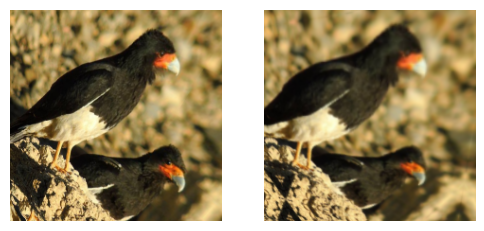

In [4]:
#hide_input
#id interpolations
#caption A comparison of fastai's data augmentation strategy (left) and the traditional approach (right).
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
# Place an image in the 'images/allkamari.jpg' subfolder where this notebook is located before running this
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'allkamari_andino_1.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

## Checking and Debuggin a DataBlock

You can use `show_batch` method to take a look at each image

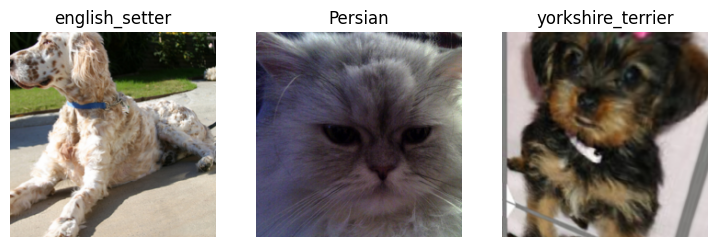

In [5]:
dls.show_batch(nrows=1, ncols=3)

In [6]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")
     


Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}


Building one sample
  Pipeline: PILBase.create
    starting from
      /teamspace/studios/this_studio/.fastai/data/oxford-iiit-pet/images/pomeranian_138.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=300x203
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

    starting from
      /teamspace/studios/this_studio/.fastai/data/oxford-iiit-pet/images/pomeranian_138.jpg
    applying partial gives
      pomeranian
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
 gives
      TensorCategory(28)

Final sample: (PILImage mode=RGB size=300x203, TensorCategory(28))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': Non

RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `TensorImage`:
	Item at index 0 has shape: torch.Size([3, 203, 300])
	Item at index 1 has shape: torch.Size([3, 500, 364])

Please include a transform in `after_item` that ensures all data of type TensorImage is the same size

The previous error shows why the images cannot be processed, int the previous case not all images have the same size. It would be needed to work in the dataset until having at least some sample to start training, test this sample anc continue to complete what is needed.

In [7]:
# Now using a learner to fit, we are fine-tunning resnet34 using our dataset
# contained in `dls' which is :
# dls = pets.dataloaders(path/"images")
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)
# The result is divided in epochs b

epoch,train_loss,valid_loss,error_rate,time
0,1.479251,0.343447,0.104871,02:36


epoch,train_loss,valid_loss,error_rate,time
0,0.523186,0.275695,0.087957,00:52
1,0.336587,0.240766,0.074425,00:39


## Cross-Entropy Loss

Is a loss function that has two benefits:

- Works for a dependent variable that has more than two categories.
- Results in faster and more reliable training.

### Checking activations and labels

In `DataLoaders` method `one_batch` returns a batch of real data from the data loader.

In [8]:
x,y = dls.one_batch()
y

TensorCategory([ 1, 35, 19, 36, 32,  4, 29,  5, 18,  2, 35, 24, 23, 21, 24, 19,
                 6, 12, 31,  9,  9, 33, 21, 16, 23, 15, 30,  3, 29, 27, 12,  5,
                 1, 36, 26, 17, 36,  8, 33, 28, 36, 25, 27, 20,  6,  4, 34, 17,
                16,  7, 28, 30, 20,  8, 36, 17, 23,  5,  1, 25, 11, 19,  4, 21],
               device='cuda:0')

The previous shows the tensor with the labels (breed lables). To check the predictions (that is, the actications of the final layer of our neural network) using `Learner.get_preds`.

In [9]:
preds,_ = learn.get_preds(dl=[(x,y)])
print(preds[0])
# The shum of all predictions add up to 1:
print(len(preds[0]),preds[0].sum())

tensor([7.7537e-04, 1.3796e-01, 4.1567e-07, 8.4148e-06, 1.2634e-04, 8.6080e-01,
        1.6776e-04, 1.8885e-05, 7.9291e-05, 1.1431e-05, 6.5640e-06, 6.5644e-06,
        2.4151e-07, 1.0577e-06, 6.5343e-07, 6.7149e-07, 2.6995e-07, 1.1173e-06,
        1.5970e-07, 4.1491e-06, 6.9275e-06, 2.7502e-07, 1.2562e-07, 1.3001e-06,
        1.2253e-07, 7.1980e-08, 6.0105e-07, 6.0419e-06, 5.2718e-07, 6.9862e-06,
        5.3837e-07, 5.8710e-07, 2.3082e-07, 8.1257e-07, 6.0498e-07, 3.4531e-07,
        4.4128e-07])
37 tensor(1.)


Now to transfoorm the activations of the model into predictions, `softmax` can be used. This is used in the final layer. Another similar function is sigmoid but it is used for *binary classification*. `softmax` is a way to apply sigmoid function to all columns.

`softmax` is used whenever we have more than two categories and the probabilities of the categories must add to 1.

In [10]:
def softmax(x): 
    return exp(x) / exp(x).sum(dim=1, keepdim=True)

## Log likelihood

For the MNIST example (a binary classification) the loss is

```python
def mnist_loss(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).mean()
```

To have this working for a multiple category problem PyTorch has `F.nll_loss` which stands for *negative log likelihood*. Log stands for the logarithmic function. It uses the logarithm because the *cross entropy loss* may involve multiplying lots of negative numbers which can lead to problems like the numerical underflow in computers. The *logarithm* only is not defined for numbers no less than 0.

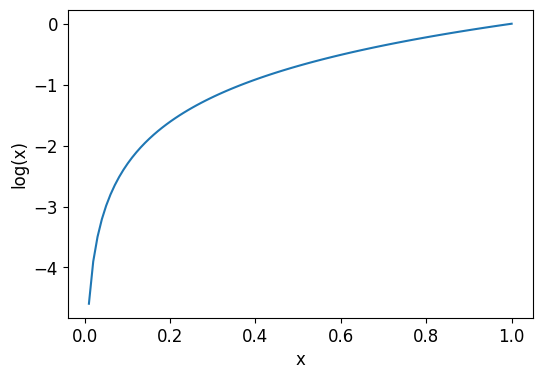

In [11]:
from fastbook import *
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

Remember some logarithm properites

$$
\begin{align}
y = b^a \\\\
a = log(y,b) \\\\
log(a \cdot b) = log(a)+log(b) \\\\
\end{align}
$$

Taking the negative of the log we can have our loss function to return a small value when the prediciton is "good" (closer to 1) and a large value when the prediction is "bad" (closer to 0).

In other words, the loss will be very large or when the prediction is wrong.  One benefit of using the log to calculate the loss is that our loss function penalizes predictions that are both confident and wrong

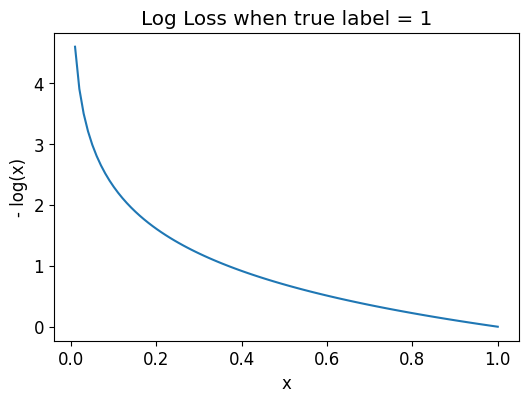

In [12]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='- log(x)', title = 'Log Loss when true label = 1')

### Negative Log Likelihood

In Pytorch the `nn.CrossEntropyLoss` is the loss function that does `log_softmax` and `nll_losss`.


In [13]:
loss_func = nn.CrossEntropyLoss()

# To avoid PyTorch loss functions take the mean of the loss of all items, reduction='none' can be used.
nn.CrossEntropyLoss(reduction='none')

CrossEntropyLoss()

## Model interpretation 

In order for people to understand and interpret the result of loss functions we need metrics. A confusion matrix can be helpful but it is not so easy to read.

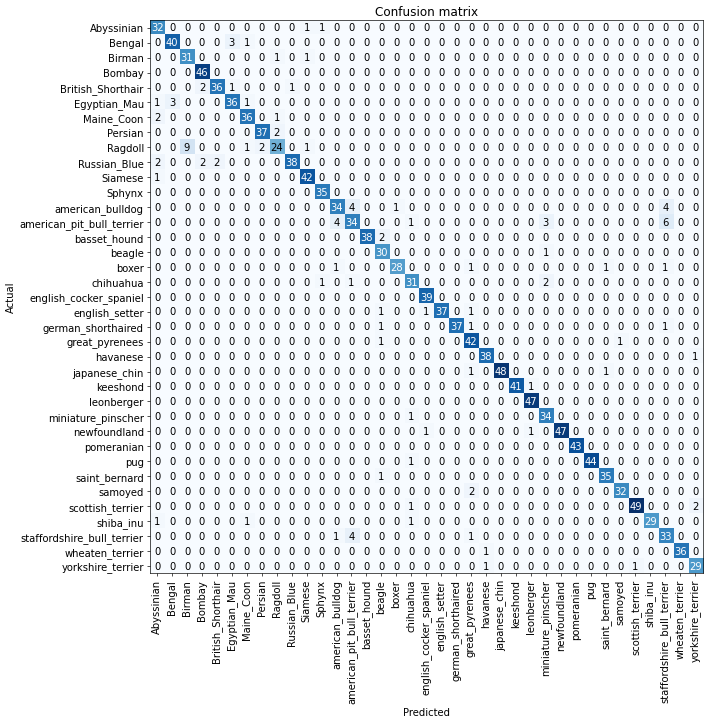

In [14]:
# The following plots a confusion matrix for predictions of every breed.
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

To focus just on the confusion's matrix cells that has the most incorrect predictions we can use `most_confused`.

In [15]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', np.int64(9)),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', np.int64(6))]

## Improving the model (Exploring transfer learning and fine-tune)

It is possible to improve the model training and make it better. While doing so, a little bit of transfer learning and how to **fine-tune** the pretrained model is possible without breaking the pretrained weights.

The following will make the learning rate very high to see what happens.

In [16]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.563825,4.926405,0.524357,00:33


epoch,train_loss,valid_loss,error_rate,time
0,3.150027,1.619857,0.464817,00:43


The previous result show high error because the optimizer stepped in the correct direction but too far overshotting the minimum loss. So what can be done to set the learning rate —not too high or too low?
There is a techniche called the **learning rate finder** which consists on starting witha very small learning rate, use a mini-bach, find what losses are afterwards, then increase the learning rate by some percentage (e.g., doubling it each time). Then do another mini-batch, track the loss, and double the learning rate again. Keep doing it until the loss gets worse. At this point we know where the learning rate was too high.

Here an example starting with a very small number given by default fastai lib. (1e-3):

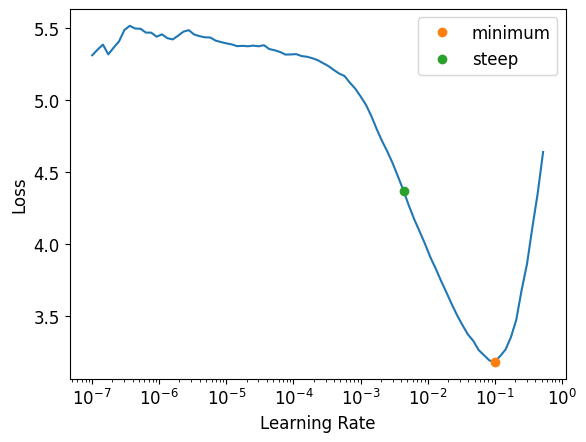

In [17]:

learn = vision_learner(dls, resnet34, metrics=error_rate)
# here lr_find would be the implementation of the learning rate finder algorith
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [18]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 4.37e-03


At this point we see that in the range of 1e-3 to 1e-3,  the model does not improves (training is not working). Then the the loss starts to decrease until reaching its minimum and starts increasing again. We can choose around 3e-3:

In [19]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)
     


epoch,train_loss,valid_loss,error_rate,time
0,1.310481,0.283330,0.089310,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.537413,0.402462,0.125846,00:41
1,0.329299,0.232680,0.073748,00:41


> It's interesting that the learning rate finder was only discovered in 2015, while neural networks have been under development since the 1950s. Throughout that time finding a good learning rate has been, perhaps, the most important and challenging issue for practitioners. The solution does not require any advanced maths, giant computing resources, huge datasets, or anything else that would make it inaccessible to any curious researcher. Furthermore, Leslie Smith, was not part of some exclusive Silicon Valley lab, but was working as a naval researcher. All of this is to say: breakthrough work in deep learning absolutely does not require access to vast resources, elite teams, or advanced mathematical ideas. There is lots of work still to be done that requires just a bit of common sense, creativity, and tenacity.

## Unfreezing and Transfer Learning

We now know that a convolutional neural network consists of many linear layers with a nonlinear activation function between each pair, followed by one or more final linear layers with an activation function such as softmax at the very end. The final linear layer uses a matrix with enough columns such that the output size is the same as the number of classes in our model (assuming that we are doing classification).

This **final linear layer is unlikely to be of any use for us when we are fine-tuning** in a transfer learning setting, because it is specifically designed to classify the categories in the original pretraining dataset. So when we do transfer learning we remove it, throw it away, and replace it with a new linear layer with the correct number of outputs for our desired task (in this case, there would be 37 activations).

The newly aded linear layer will have entirely random weights. Therefore, our model prior to fin-tunning has entiruely random outputs. However it is not entirely random model, all previous layers have were trained to be good at image classification. 

We will train a model in a way that it remmbers generally useful ideias from the pretrained model, use them to solve our particular task (in this case classify pet breeds), and only adjust them as required for the specifics of our particular task.

The challange while fine-tunning is to replace the random weights in our added linear leayers with weights that correctly achieve our desired task **without** breaking the carefully pretrained weights and the other layers. This is tell the optimizer to only update the weights in those randomly added final layers **without** changing the weights in the rest of the neural network at all. This is called *freezing* those pretrained layers.

When creating a model from a pretrained network fastai automatically freezes all the pretrained layers when calling `fine_tune` method fastai does two things:

- Trains the randomly added layers for one epoch with all other layers frozen
- Unfreezes all of the layers, and trains them for the number of epochs requested.

However you may get better results by changing this. We will train the randomly added layers for three epochs using `fit_one_cycle`. This is a way to train models without using `fine_tune`. 

In [20]:
# to see the code of fine_tune method
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      /home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/fastai/callback/schedule.py
Type:      method

In [21]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
# three epochs with the previously found learning rate
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.136776,0.321468,0.107578,00:38
1,0.540508,0.262463,0.085250,00:38
2,0.315926,0.228882,0.074425,00:36


Now we will unfreeze the model with `learn.unfreeze`. After that we'll run `lr_find` again because having more layers to train, means our previously found learning rate isn't appropriate any more.

SuggestedLRs(valley=3.311311274956097e-06)

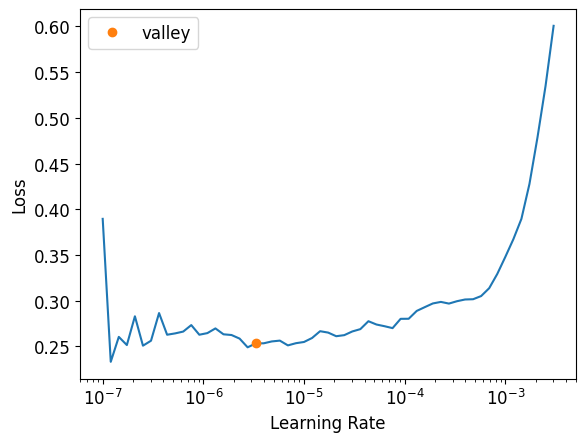

In [22]:
learn.unfreeze()
learn.lr_find()

Here the loss does not starts constantly decreasing as before because most of the model was already trained. We have a somewhat flat area before sharp increase, we should take this. Let's test again with this new learning rate.

In [23]:
learn.fit_one_cycle(6, lr_max=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.277713,0.257692,0.079161,00:43
1,0.302431,0.315857,0.093369,00:39
2,0.236235,0.267056,0.079838,00:42
3,0.182538,0.245060,0.068336,00:42
4,0.128373,0.201873,0.062246,00:41
5,0.089212,0.199071,0.057510,00:40


It improves but the deepest layers of the pretrained model might no need as high learning rate as the last one, we should probably use different learning rates for those—this is known as using discriminative learning rates.
 
### Discriminative learning rates.

Having in midin that we have tunned those randomly added parameters for a few epochs, the pretrained weights have been trained for hundreds of epoch in this case for million of images. Fastai default approach is tu use discriminative learning rates. This is use a lower learning rate for the early layers of the neural network, and higher learning rate for the later layers (especially the randomly added layers).

![Idea developed based on insights developed by Jason Yosinski](https://raw.githubusercontent.com/fastai/fastbook/e8baa81d89f0b7be816e35f1cc813ac02038db54/images/att_00039.png)

fastai lets you pass a Python `slice` obhect anywhere that a learning rate is expected. Taking advantage of this, we will have learning rates that start with the **lowest** layer of our net to a learning rate of $1^{-6}$; the other layers will scale up to $1^{-4}$.

In [24]:
# at this point the pretrained layers are freezed
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
# now we unfreeze
learn.unfreeze()
# 12 epochs, slice the learning rate for first layers 1e-6 scale up to 1e-4
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.122955,0.342539,0.104195,00:37
1,0.515344,0.270249,0.087280,00:33
2,0.318848,0.224387,0.072395,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.261286,0.217713,0.068336,00:42
1,0.243192,0.211647,0.063599,00:40
2,0.235963,0.199842,0.062246,00:40
3,0.218674,0.189702,0.058187,00:42
4,0.190761,0.191914,0.057510,00:43
5,0.188245,0.186612,0.061570,00:42
6,0.160545,0.189946,0.057510,00:41
7,0.146017,0.180164,0.058187,00:40
8,0.141636,0.182595,0.054127,00:42
9,0.129318,0.182106,0.058863,00:41


We can see the fine-tuning is working. Let's see a graph.

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

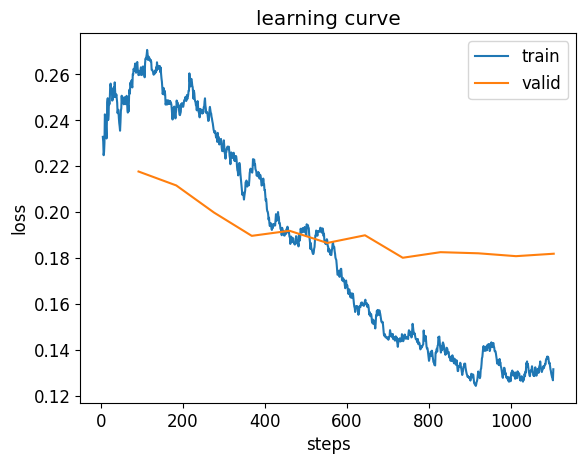

In [25]:
learn.recorder.plot_loss()

The training loss keeps getting better and better, the validation loss improvement slows and eventually gets worse, that would mean the model is starting to *over fit*. At the end generally what matters is the accuracy or your chosen metris, not the loss.

## Selecting the number of Epochs

To avoid overprocessing the data by running additional epochs when the choosen metrics start to get worse because the model gets overconfident, we will need to know when to stop. To avoid *early stopping* because ther could be some *middle* epochs before the learning rate has had a chance to reach the small values, what you actually do is retrain your model from scratch and select a total number of epochs based on where your previous best result were found.

### Deeper architectures

In general, a model with more parameters can model your data more accurately. Since we wna t to use pretrained models, we need to make sure that we choose a number of layers that have already been pretrained for us, plus a deeper model is going to require more GPU RAM, so it is needed to lower the size of your batches to avoid *out-of-memory error*. `Cuda runtime error: out of memory`.

We will try a ResNet-50 with mixed precision —this is use less-precise numbers like *half-precision floating point* also called *fp16*.

In [26]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
# fine_tune has the freeze_epoch to tell how many to train with frozen early pretrained weights.
learn.fine_tune(6, freeze_epochs=3)     

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /teamspace/studios/this_studio/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.274313,0.490803,0.149526,00:38
1,0.865178,0.331358,0.101489,00:32
2,0.521721,0.362875,0.112991,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.291081,0.253692,0.083221,00:40
1,0.249232,0.243025,0.077131,00:40
2,0.195955,0.212061,0.058863,00:40
3,0.133705,0.198701,0.065629,00:40
4,0.089331,0.188400,0.057510,00:40
5,0.062054,0.182693,0.056157,00:40


In this case a deeper model is not doing decisively better—bigger models aren't necessarily better models for your particular cases! Better to try small models before scaling up.